In [3]:
import torch
import csv

import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models

from captum.attr import Deconvolution
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.metrics import infidelity, sensitivity_max, infidelity_perturb_func_decorator

from helpers import get_labels, get_input_image, predict

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

## Initialize Resnet18

[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

In [4]:
model = models.resnet18(pretrained=True)
model = model.eval()

## Extract ImageNet class labels and get correct predicted label id for default image

In [5]:
labels_path, idx_to_labels = get_labels()
input, transformed_img = get_input_image()

In [6]:
predicted_label, pred_label_idx, prediction_score = predict(model, input, idx_to_labels)
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: goose ( 0.4569336771965027 )


## Get Deconvolution attribution

[Visualizing and Understanding Convolutional Networks, Matthew D Zeiler et al. 2014](https://arxiv.org/pdf/1311.2901.pdf)

In [7]:
deconv = Deconvolution(model)
attributions_deconv = deconv.attribute(input, target=pred_label_idx)

/home/piro/anaconda3/envs/assignment-1-burnpiro/lib/python3.8/site-packages/captum/_utils/gradient.py:53: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/piro/anaconda3/envs/assignment-1-burnpiro/lib/python3.8/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:60: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


In [9]:
attributions_deconv.shape

torch.Size([1, 3, 224, 224])

## Generate explanation with NoiseTunnel

[Sanity Checks for Saliency Maps, Julius Adebayo et al. 2018](https://arxiv.org/abs/1810.03292)

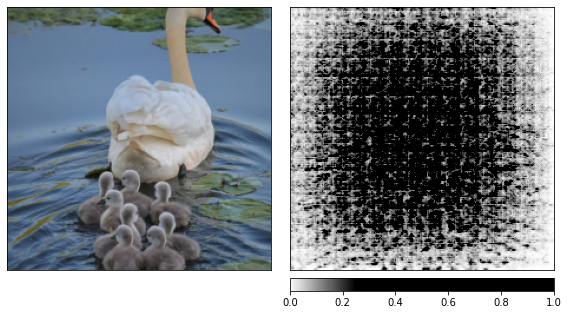

In [6]:
noise_tunnel = NoiseTunnel(deconv)

attributions_deconv_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_deconv_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

## Calculate Infidelity and Sensitivity metrics

[On the (In)fidelity and Sensitivity for Explanations](https://arxiv.org/abs/1901.09392)

In [10]:
# We need that for metric calculation
input.requires_grad = True

In [11]:
def perturb_fn(inputs):
    noise = torch.tensor(np.random.normal(0, 0.003, inputs.shape)).float()
    return noise, inputs - noise

infid = infidelity(model, perturb_fn, input, attributions_deconv, target=pred_label_idx)

In [12]:
sens = sensitivity_max(deconv.attribute, input, target=pred_label_idx)

In [13]:
print(f"Infidelity: {infid.numpy()[0]}, Sensitivity: {sens.numpy()[0]}")

Infidelity: 0.011272077448666096, Sensitivity: 0.43327516317367554


### Append results to results file

In [11]:
fields=['Deconv',infid.numpy()[0],sens.numpy()[0]]
with open('../data/results.csv','a') as fd:
    writer = csv.writer(fd)
    writer.writerow(fields)